# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as pl

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

2023-12-04 19:38:44.010240: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 19:38:44.080392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:38:44.430944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 19:38:44.431118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 19:38:44.493490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

First, create some useful functions

In [2]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()
    
    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))    
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Split the training set into a training set and a validation set
X_val = X_train[0:10000,:,:]
X_train = X_train[10000:,:,:]
y_val = y_train[0:10000]
y_train = y_train[10000:]

n_train, height, width = X_train.shape
n_val, _, _ = X_val.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_val = X_val.reshape(n_val, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_val, 'validation samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(y_val, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

50000 train samples
10000 validation samples
10000 test samples


In [4]:
width

28

Create the CNN and show its architecture

In [5]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

# l3 = Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
# l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l2_mp)

l4 = Dense(100, activation='relu', name='l4')(flat)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (InputLayer)             [(None, 28, 28, 1)]       0         
                                                                 
 l1 (Conv2D)                 (None, 28, 28, 9)         234       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 9)         0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 9)         2034      
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 9)           0         
                                                                 
 flat (Flatten)              (None, 441)               0         
                                                                 
 l4 (Dense)                  (None, 100)               44200 

Define some constants and train de CNN. In order to perform the model selection process, you train each model with the train dataset and evaluate it with the validation dataset. The test set remains unseen.

In [6]:
batch_size = 128
n_epoch = 5

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/5
391/391 [==============================] - 6s 14ms/step - loss: 0.3232 - accuracy: 0.9016 - val_loss: 0.1055 - val_accuracy: 0.9660
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0828 - accuracy: 0.9742 - val_loss: 0.0631 - val_accuracy: 0.9814
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0576 - accuracy: 0.9817 - val_loss: 0.0746 - val_accuracy: 0.9753
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0601 - val_accuracy: 0.9809
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0367 - accuracy: 0.9881 - val_loss: 0.0467 - val_accuracy: 0.9867


Show the performance of the model. By observing the performance of your models on the validation set, you will choose a set of hyperparameters for your final model. The test set is still not used at this point.

Validation score: 0.04674063250422478
Validation accuracy: 0.9866999983787537


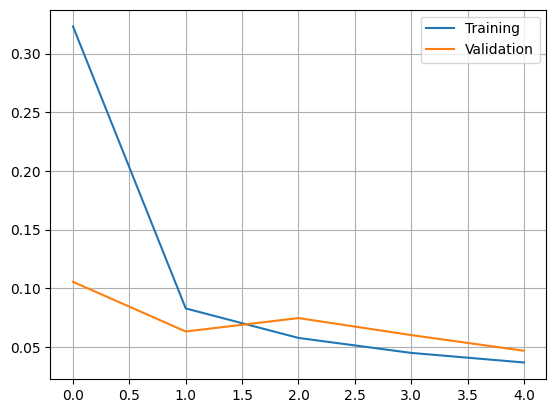

In [7]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Validation')
pl.legend()
pl.grid()

score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

Now that you have chosen your final model, you can finally evaluate its performance using the test set. It is important that the test set remains hidden for your model until this last step in order to have an unbiased estimate of the performance. Therefore, you should not run the following cell until you have chosen your final model.

In [8]:
final_score = model.evaluate(X_test, Y_test, verbose=0)
print('FINAL RESULTS:')
print('Test score:', final_score[0])
print('Test accuracy:', final_score[1])

FINAL RESULTS:
Test score: 0.03727954253554344
Test accuracy: 0.9869999885559082


Confusion matrix

In [9]:
pred = model.predict_on_batch(X_test)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

array([[ 976,    0,    0,    0,    0,    1,    0,    1,    2,    0],
       [   0, 1122,    1,    2,    0,    1,    1,    4,    4,    0],
       [   5,    2, 1011,    1,    1,    0,    0,    6,    6,    0],
       [   1,    0,    0, 1001,    0,    4,    0,    2,    2,    0],
       [   0,    0,    1,    0,  969,    0,    0,    0,    1,   11],
       [   1,    0,    1,    4,    0,  882,    2,    1,    0,    1],
       [   7,    2,    0,    0,    3,    3,  939,    0,    4,    0],
       [   0,    2,    2,    1,    0,    0,    0, 1021,    1,    1],
       [   3,    0,    0,    2,    0,    3,    0,    1,  962,    3],
       [   2,    3,    0,    1,    2,    4,    0,    7,    3,  987]])